# Neural Network for blood cells

Der Datensatz besteht aus mikroskopischen Bildern von Blutzellen, diese sind in acht Kategorien aufgeteilt:
1. basophil
2. eosinophil
3. erythroblast
4. ig
5. lymphocyte
6. monocyte
7. neutrophil
8. platelet

## Daten importieren und vorbereiten
Die Daten werden aus dem Verzeichnis geladen und verarbeitet. Die grösse wird auf 224 x 224 Pixel gesetzt und die Bilder werden durchgemischt und in Batches mit je 32 Bildern geladen. 20% der Daten werden zur validation behalten. Die verbleibenden 80% werden erneut aufgeteilt, wobei 80% als Trainingsdaten und 20% als Validierungsdaten dienen. Dies führt zu einem Trainingssatz mit 64%, einem Validierungssatz mit 16% und einem Testdatensatz mit 20% der Bilder.  

In [2]:
import os
import keras

# Import and prepare the first split of datasets
path = os.path.join("images/archive/bloodcells_dataset/")

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Use image_dataset_from_directory to load your data
dataset, test_dataset = keras.utils.image_dataset_from_directory(
    directory=path,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="both",
    shuffle=True,
    seed=42
)

# Get class names
class_names = dataset.class_names
print(class_names)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.
['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


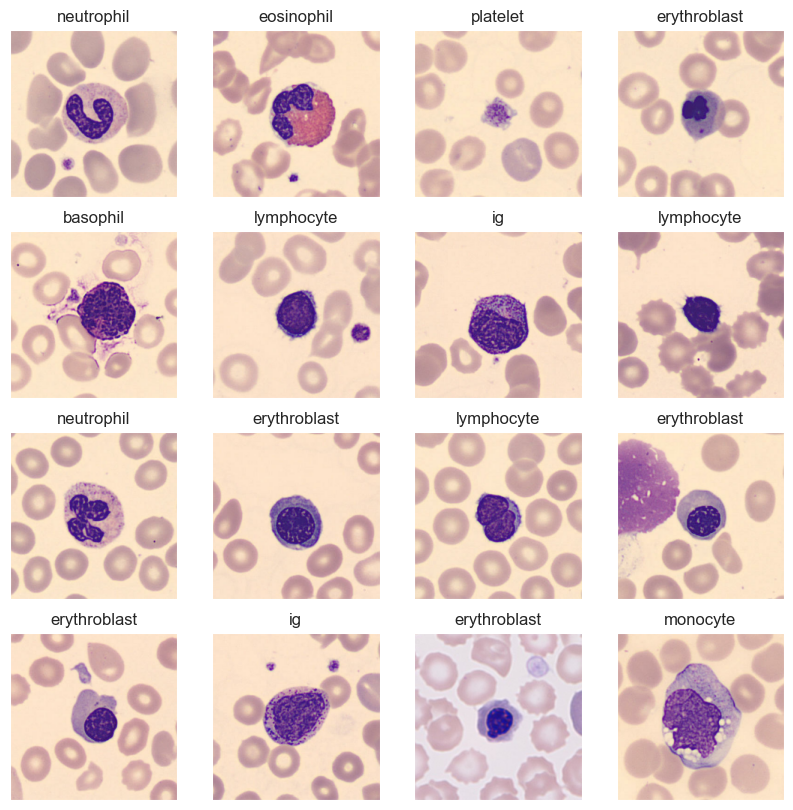

In [3]:
from matplotlib import pyplot as plt

# Plot 16 images from the dataset as examples
fig, ax = plt.subplots(4, 4, figsize=(10,10))
ax = ax.flat
for images, labels in dataset.take(1):
  for i in range(16):
    ax[i].set_title(class_names[labels[i].numpy()])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(images[i].numpy().astype("uint8"))

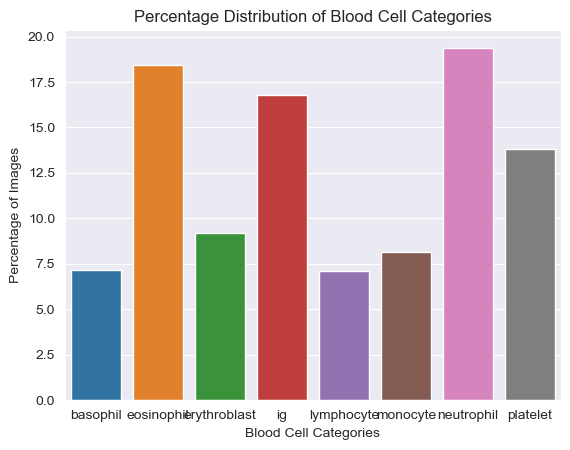

In [5]:
import numpy as np
import seaborn as sns

# Convert labels to NumPy array
labels_array = np.concatenate([labels.numpy() for images, labels in dataset], axis=0)

# Get the class distribution from the dataset
class_distribution = [np.sum(labels_array == i) for i in range(len(class_names))]

# Calculate the percentage distribution
total_samples = sum(class_distribution)
class_percentages = [(count / total_samples) * 100 for count in class_distribution]

# Create a countplot using seaborn with percentages
sns.barplot(x=class_names, y=class_percentages)
plt.xlabel('Blood Cell Categories')
plt.ylabel('Percentage of Images')
plt.title('Percentage Distribution of Blood Cell Categories')
plt.show()

In [8]:
import tensorflow as tf

# Get the total number of elements in the dataset
num_elements = len(dataset)

# Calculate the size of the training set (80% of the total dataset)
train_size = int(0.8 * num_elements)

# Skip the first 'train_size' elements to create the validation dataset
# and prefetch the data for improved performance
val_dataset = dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)

# Take the first 'train_size' elements to create the training dataset
# and prefetch the data for improved performance
train_dataset = dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

# Check the lengths of the resulting datasets
len(train_dataset), len(val_dataset), len(test_dataset) # Output is in batches, BATCH_SIZE=32

(342, 86, 107)

In [10]:
# Check format of the batches, should be -> (32, 224, 224, 3)
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [11]:
# Check pixel intesities
for image, label in train_dataset.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(255.0, shape=(), dtype=float32)
tf.Tensor(0.5161629, shape=(), dtype=float32)


**Fazit:**
* Die 8 Klassen sind unausgeglichen, wobei die häufigste Klasse die Neutrophilen mit 19,4% aller Bilder und die seltenste Klasse die Lymphozyten mit 7,1% ist. Daher würde die Genauigkeit eines zufälligen Modells 19,4% betragen.
* Die Pixelintensitäten reichen von 3,5 bis 255. Daher ist eine Neuskalierung der Pixelintensitäten angemessen.


## Model 1 - 